<a href="https://colab.research.google.com/github/guide2157/Seq2Seq2Summarizer/blob/master/AmazonReviewSeq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, TimeDistributed, Attention, Bidirectional,Concatenate
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!pip install tqdm

In [0]:
import os
from tqdm.notebook import tqdm

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Import Amazon Review Dataset

In [0]:
dataset = pd.read_csv("Reviews.csv")
dataset = dataset.dropna()
text = dataset['Text']
summary = dataset['Summary']

Import BBC News Dataset

In [6]:
news_text = []
news_summary=[]

input_path_tx = 'drive/My Drive/BBC News Summary/News Articles'
# input_path_sum = 'drive/My Drive/BBC News Summary/Summaries'
for cat in tqdm(os.listdir(input_path_tx)):
  current_dir_tx = os.path.join(input_path_tx, cat)
  # current_dir_sum = os.path.join(input_path_sum, cat)
  for file in tqdm(os.listdir(current_dir_tx)):
    try:
      with open(os.path.join(current_dir_tx,file), 'r') as file1:
        data_sum = file1.readline()
        data_tx = file1.read().replace('\n', '')
      # with open(os.path.join(current_dir_sum,file), 'r') as file2:
      #   data_sum = file2.read().replace('\n', '')
      news_text.append(data_tx)
      news_summary.append(data_sum)
    except:
      continue

In [0]:
def clean_text(text, add_signal=False, remove_stopwords=True):
    text = text.lower()

    text = text.split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)

    text = " ".join(new_text)

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'<br  >', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    if add_signal:
      text = '_START_ '+ str(text) + ' _END_'

    return text


Clean Dataset

In [14]:
cleaned_summary_news = []
for t in tqdm(news_summary):
    cleaned_summary_news.append(clean_text(t, True))

In [15]:
cleaned_text_news = []
for t in tqdm(news_text):
    cleaned_text_news.append(clean_text(t))

In [17]:
cleaned_summary = []
for t in tqdm(summary):
    cleaned_summary.append(clean_text(t, True))

In [18]:
cleaned_text = []
for t in tqdm(text):
    cleaned_text.append(clean_text(t))

Detemine Input Size

Text(0.5, 1.0, 'News summaries length')

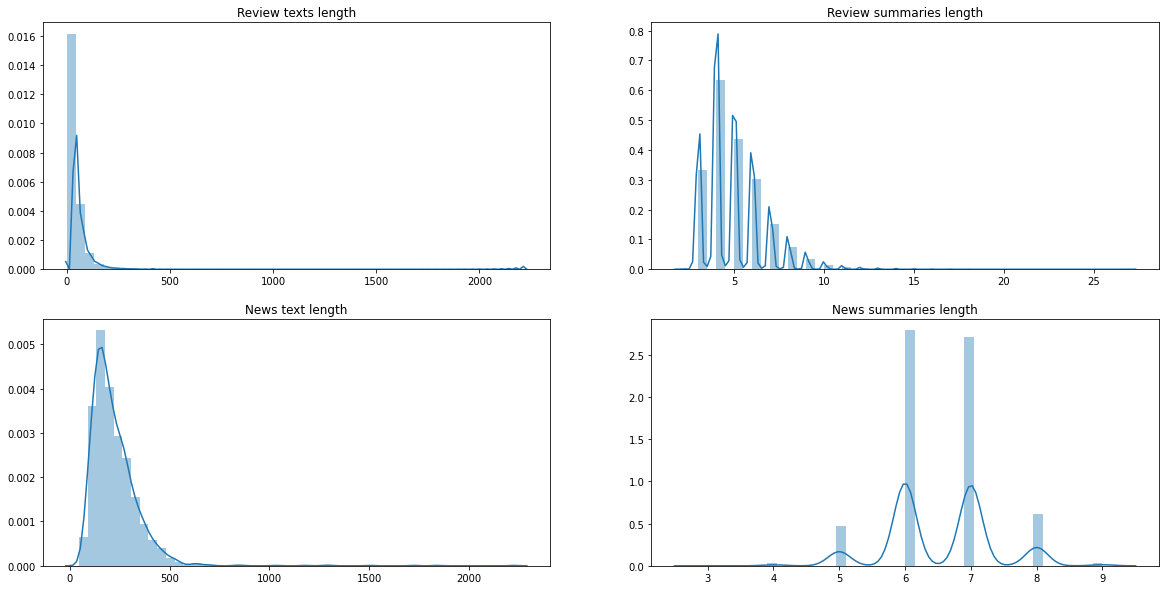

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

len_text = [len(i.split()) for i in cleaned_text]
len_sum = [len(i.split()) for i in cleaned_summary]

len_text_news = [len(i.split()) for i in cleaned_text_news]
len_sum_news = [len(i.split()) for i in cleaned_summary_news]

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.distplot(len_text)
plt.title("Review texts length")

plt.subplot(2,2,2)
sns.distplot(len_sum)
plt.title("Review summaries length")

plt.subplot(2,2,3)
sns.distplot(len_text_news)
plt.title("News text length")

plt.subplot(2,2,4)
sns.distplot(len_sum_news)
plt.title("News summaries length")

# sns.distplot(len_sum)
# plt.title("Summaries length")
# plt.show()

In [0]:
max_len_text =250
max_len_summary=10

In [95]:
print(cleaned_text[0])
print(cleaned_summary[0],'\n')

print(cleaned_text_news[0])
print(cleaned_summary_news[0])

bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
_START_ good quality dog food _END_
mac mini cheapest apple computer ever though cheap mac compare pcs cost amount dot life tries find get money stick beige box extremely small computer designed bring macintosh masses apple offer less powerful mac mini £339 £399 models 1 4ghz power pc chip 80 gigabyte hard drive combined cd burner dvd player comes equipped usb firewire ports peripheral connections ethernet port broadband port standard video output audio headphone jack machine comes mac os x apple operating system software suite ilife includes itunes iphoto imovie idvd garageband monitor keyboard mouse also built support wireless technology speakers lack dvd burner omission age backing important software wireless dvd burner added extra cost apple targeting people already main computer want upgrade especially pc users used ap

In [0]:
cleaned_text = cleaned_text + cleaned_text_news
cleaned_summary = cleaned_summary + cleaned_summary_news

Tokenize sentences

In [0]:
from keras.preprocessing.text import Tokenizer 

x_tokenizer = Tokenizer(oov_token='UNK',filters='',lower=False)
x_tokenizer.fit_on_texts(cleaned_text)
x_sequences = x_tokenizer.texts_to_sequences(cleaned_text)

y_tokenizer = Tokenizer(oov_token='UNK', filters='',lower=False)
y_tokenizer.fit_on_texts(cleaned_summary)
y_sequences = y_tokenizer.texts_to_sequences(cleaned_summary)

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

    return word_to_vec_map

In [0]:
X_train, X_val, y_train, y_val = train_test_split(x_sequences, y_sequences, test_size=0.1,
                                                random_state=42, shuffle=True)

In [0]:
X_train = pad_sequences(X_train, maxlen=max_len_text, padding='post')
X_val = pad_sequences(X_val, maxlen=max_len_text, padding='post')

In [0]:
y_train = pad_sequences(y_train, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')

Import Glove vec

In [0]:
word_to_vec_map = read_glove_vecs("glove.6B.100d.txt")

In [0]:
def Glove_Embedding(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["the"].shape[0]
    emb_matrix = np.zeros([vocab_len, emb_dim])

    for word, idx in word_to_index.items():
        if word in word_to_vec_map:
            emb_matrix[idx, :] = word_to_vec_map[word]
        else:
            emb_matrix[idx, :] = np.array(np.random.uniform(-1.0, 1.0, emb_dim))

    embedding_layer = Embedding(vocab_len, emb_dim)
    embedding_layer.trainable = False

    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

Model Construction

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, word_to_vec_map, words_to_index, latent_dim):
    super(Encoder, self).__init__()
    self.latent_dim = latent_dim
    self.embedding_layer = Glove_Embedding(word_to_vec_map, words_to_index)
    # self.embedding_layer = Embedding(len(words_to_index) + 1, latent_dim)
    self.lstm1 = Bidirectional(LSTM(latent_dim, dropout=0.2, return_state=True, return_sequences=True))

  def call(self,inputs):
    embed = self.embedding_layer(inputs)
    encoder_output1, f_state_h, f_state_c, b_state_h, b_state_c = self.lstm1(embed)
    state_h= Concatenate()([f_state_h, b_state_h])
    state_c= Concatenate()([f_state_c, b_state_c])
    return encoder_output1, state_h, state_c

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, word_to_vec_map, words_to_index, latent_dim):
    super(Decoder, self).__init__()
    self.latent_dim = latent_dim
    # self.embedding_layer = Embedding(len(words_to_index) + 1, latent_dim)
    self.embedding_layer = Glove_Embedding(word_to_vec_map, words_to_index)
    self.lstm = LSTM(latent_dim * 2, return_sequences=True, return_state=True,dropout=0.2)
    self.attention = Attention()
    self.time_dist = TimeDistributed(Dense(len(words_to_index) + 1, activation='softmax'))

  def call(self, inputs, encoder_output, states):
    state_h, state_c = states
    embed = self.embedding_layer(inputs)
    lstm_out, state_h, state_c = self.lstm(embed, initial_state=[state_h, state_c])
    attn_out = self.attention([lstm_out, encoder_output]) 
    decoder_concat_input = tf.concat([lstm_out, attn_out], axis=-1)
    outputs = self.time_dist(decoder_concat_input)  
    return outputs, state_h, state_c

In [0]:
def Text_Summarizer(max_len_text, max_len_sum, word_to_vec_map, x_words_to_index, y_words_to_index, latent_dim=100):

    encoder_input = Input(shape=(max_len_text, ), dtype="int32")
    encoder = Encoder(word_to_vec_map,x_words_to_index, latent_dim)
    encoder_outputs, state_h, state_c = encoder(encoder_input)

    decoder_input = Input(shape=(None, ))
    decoder = Decoder(word_to_vec_map,y_words_to_index,latent_dim)
    output, decoder_state_h, decoder_state_c = decoder(decoder_input, encoder_outputs, (state_h, state_c))

    model = Model([encoder_input, decoder_input], output)

    encoder_model = Model(inputs=encoder_input,outputs=[encoder_outputs, state_h, state_c])


    decoder_state_input_h = Input(shape=(latent_dim *2,))
    decoder_state_input_c = Input(shape=(latent_dim * 2,))

    decoder_encoder_input = Input(shape=(max_len_text,latent_dim *2, ))

    output2, decoder_state_h2, decoder_state_c2 = decoder(decoder_input, decoder_encoder_input, (decoder_state_input_h, decoder_state_input_c))


    decoder_model = Model(
    [decoder_input] + [decoder_encoder_input]+[decoder_state_input_h, decoder_state_input_c],
    outputs=[output2]+[decoder_state_h2, decoder_state_c2])

    return model, encoder_model, decoder_model

In [0]:
x_words_to_index = x_tokenizer.word_index
y_words_to_index = y_tokenizer.word_index

In [0]:
model, encoder_model, decoder_model = Text_Summarizer(max_len_text,max_len_summary, word_to_vec_map ,x_words_to_index, y_words_to_index)

In [146]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_7 (Encoder)             ((None, 250, 200), ( 12370100    input_28[0][0]                   
__________________________________________________________________________________________________
decoder_5 (Decoder)             ((None, None, 35131) 17841431    input_29[0][0]                   
Total params: 30,211,531
Trainable params: 14,489,131
Non-trainable params: 15,722,400
____

In [0]:
 optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
 model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

Model Training

In [149]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
!rm -rf ./log/

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True)

earlyStop = EarlyStopping(patience=2)

reduceLr = ReduceLROnPlateau(factor=0.2, patience=1)

In [0]:
callbacks = [ 
             tbCallBack,
             earlyStop,
             reduceLr
]

In [161]:
history=model.fit([X_train,y_train[:,:-1]], 
                  y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,
                  epochs=50,
                  callbacks=callbacks,
                  batch_size=256, 
                  validation_data=([X_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

2014/2014 [==============================] - 251s 124ms/step - loss: 2.0097 - val_loss: 1.7379 - lr: 0.0100
Epoch 2/50
2014/2014 [==============================] - 250s 124ms/step - loss: 1.6740 - val_loss: 1.6415 - lr: 0.0100
Epoch 3/50
2014/2014 [==============================] - 252s 125ms/step - loss: 1.5664 - val_loss: 1.6071 - lr: 0.0100
Epoch 4/50
2014/2014 [==============================] - 252s 125ms/step - loss: 1.5077 - val_loss: 1.5936 - lr: 0.0100
Epoch 5/50
2014/2014 [==============================] - 252s 125ms/step - loss: 1.5788 - val_loss: 1.6494 - lr: 0.0100
Epoch 6/50
2014/2014 [==============================] - 252s 125ms/step - loss: 1.4307 - val_loss: 1.5847 - lr: 0.0020
Epoch 7/50
2014/2014 [==============================] - 252s 125ms/step - loss: 1.3983 - val_loss: 1.5730 - lr: 0.0020
Epoch 8/50
2014/2014 [==============================] - 251s 125ms/step - loss: 1.3791 - val_loss: 1.5646 - lr: 0.0020
Epoch 9/50
2014/2014 [==============================] - 251

In [0]:
%tensorboard --logdir log

Inference

In [0]:
reverse_word_map = dict(map(reversed, y_tokenizer.word_index.items()))

In [0]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = y_words_to_index['_START_']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_word_map[sampled_token_index]

        if(sampled_token!='_END_'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token ==  '_END_' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
decoder_model.load_weights("summarizer_decoder_weight.h5")
encoder_model.load_weights("summarizer_encoder_weight.h5")

In [253]:
decode_sequence(X_val[900].reshape(1,max_len_text))

' great product'

In [0]:
val_text = x_tokenizer.sequences_to_texts(X_val)

In [252]:
val_text[900]

'back mn visiting relatives realized whole grain items house like whole wheat whole grain added sugar products better oats products ones added items run favorite site retailer big bulls eye place found picked daughter loved found wonderful flavor easy prepare good serving size really liked texture mushy runny never liked instant oatmeal life want regular solid oatmeal need prepare hurry need give try UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 

In [0]:
val_sum = y_tokenizer.sequences_to_texts(y_val)

In [254]:
val_sum[900]

'_START_ outstanding great taste mushy flavorful _END_ UNK UNK UNK'

Model saving

In [0]:
decoder_model.save_weights("summarizer_decoder_weight.h5")
encoder_model.save_weights("summarizer_encoder_weight.h5")

In [0]:
import pickle

with open('x_tokenizer.pickle', 'wb') as handle1:
    pickle.dump(x_tokenizer, handle1, protocol=pickle.HIGHEST_PROTOCOL)

with open('y_tokenizer.pickle', 'wb') as handle2:
    pickle.dump(y_tokenizer, handle2, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}